<a href="https://colab.research.google.com/github/DOgaro/Twitter-Sentiment-Analysis/blob/master/BERT%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q -U watermark

In [0]:
# INSTALLING PYTORCH TRANSFORMERS LIBRARY BY HUGGING FACE FOR PERFOMING BERT 

!pip install -qq transformers

In [158]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.10.0


In [160]:
# IMPORTING THE NECESSARY LIBRARIES THAT WILL BE USED FOR PERFORMING SENTIMENT ANALYSIS

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [161]:
# NUMBER 1: DATA EXPLORATION AND PREPROCESSING
# DATASET WAS OBTAINED FROM VARIOUS TWITTER DISCUSSIONS AND COMMENTS USING TWEEPY LIBRARY AND TWITTER API
from google.colab import files
upload=files.upload() # LOADING DATA FROM OUR LOCAL MACHINE

Saving dataset.csv to dataset (2).csv


In [162]:
# READING THE DATASET AND DISPLAYING ITS CONTENTS
data=pd.read_csv('dataset.csv', header=0)
data.head()

,id,Sentiment,Tweet
0,1,Neutral,Mix rottweiler
1,2,Neutral,Ei herh sister
2,3,Neutral,offeibea Ich liebe dich
3,4,Neutral,wow so viel affection hatte ich lange nicht mehr
4,5,Neutral,lockdown socialdistance bicycle spandex life a...


In [163]:
data.shape # DATASET SHAPE (No. OF ROWS AND COLUMNS)

(7092, 3)

In [164]:
data.info() # DATASET INFORMATION (DATA TYPE AND NULL COUNT)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7092 entries, 0 to 7091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7092 non-null   int64 
 1   Sentiment  7092 non-null   object
 2   Tweet      7091 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.3+ KB


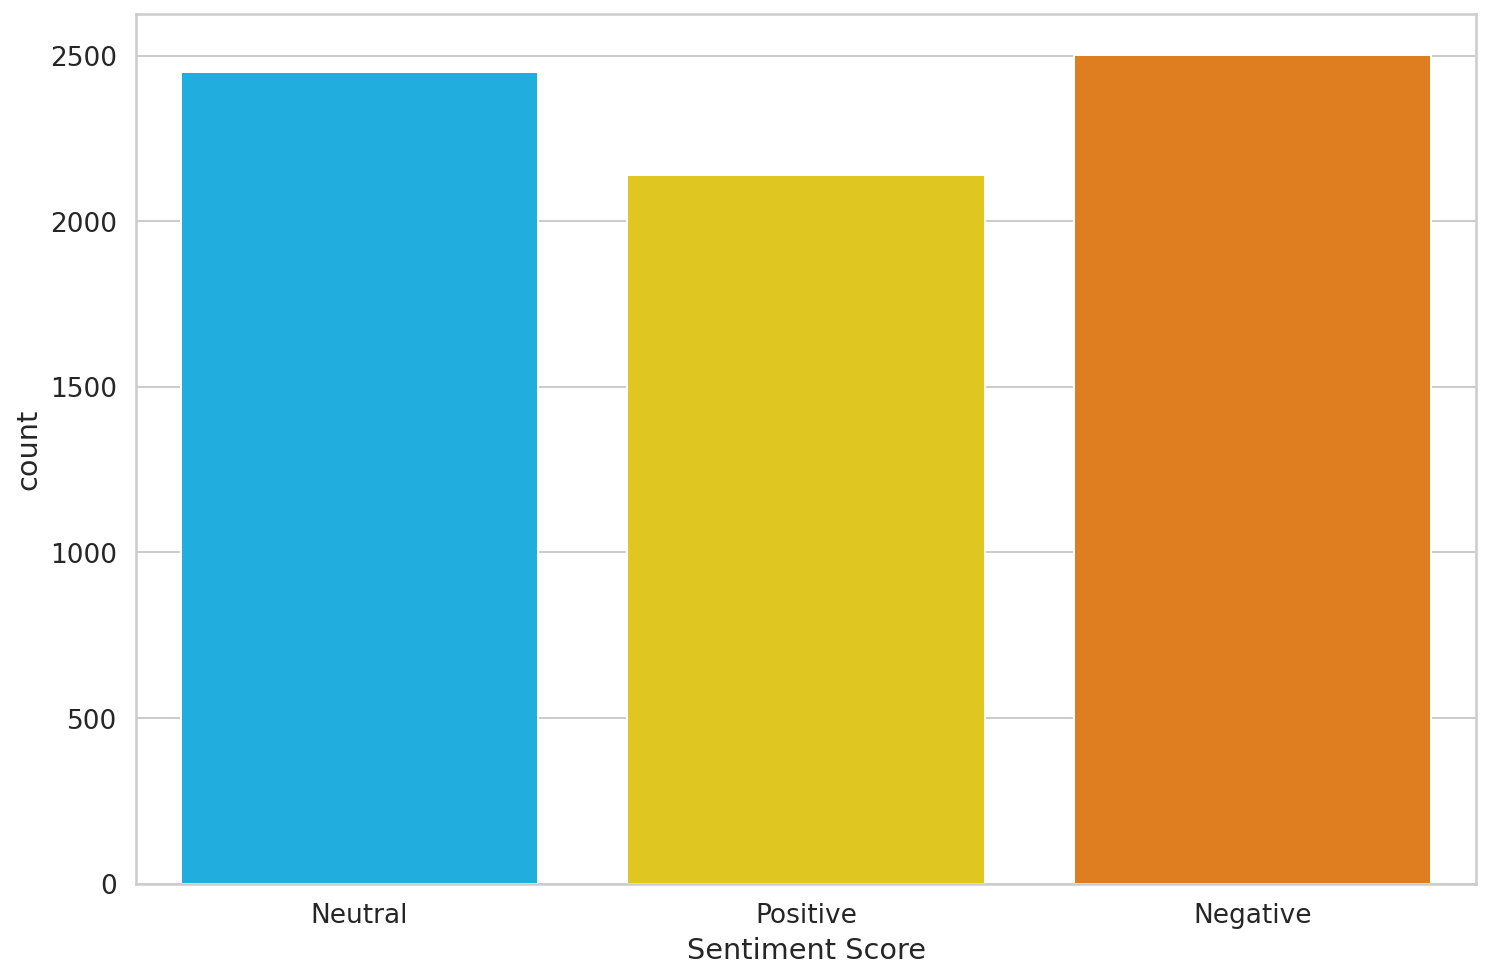

In [165]:
# PLOTTING THE DISTRIBUTION OF THE SENTIMENTS
sns.countplot(data.Sentiment)
plt.xlabel('Sentiment Score'); # LABELLING THE X-AXIS OF THE GRAPH
from google.colab import files
plt.savefig('Sentiment.pdf')     # SAVING THE PLOTTED GRAPH
files.download('Sentiment.pdf')  # DOWNLOADING THE PLOTTED GRAPH

In [0]:
# INITIALIZING THE SENTIMENTS
def to_sentiment(rating):
  rating = str(rating)
  if rating == 'Negative':
    return 0
  elif rating == 'Neutral':
    return 1
  else:
    return 2
data['sentiment'] = data.Sentiment.apply(to_sentiment)

In [0]:
class_names = ['Negative', 'Neutral', 'Positive']

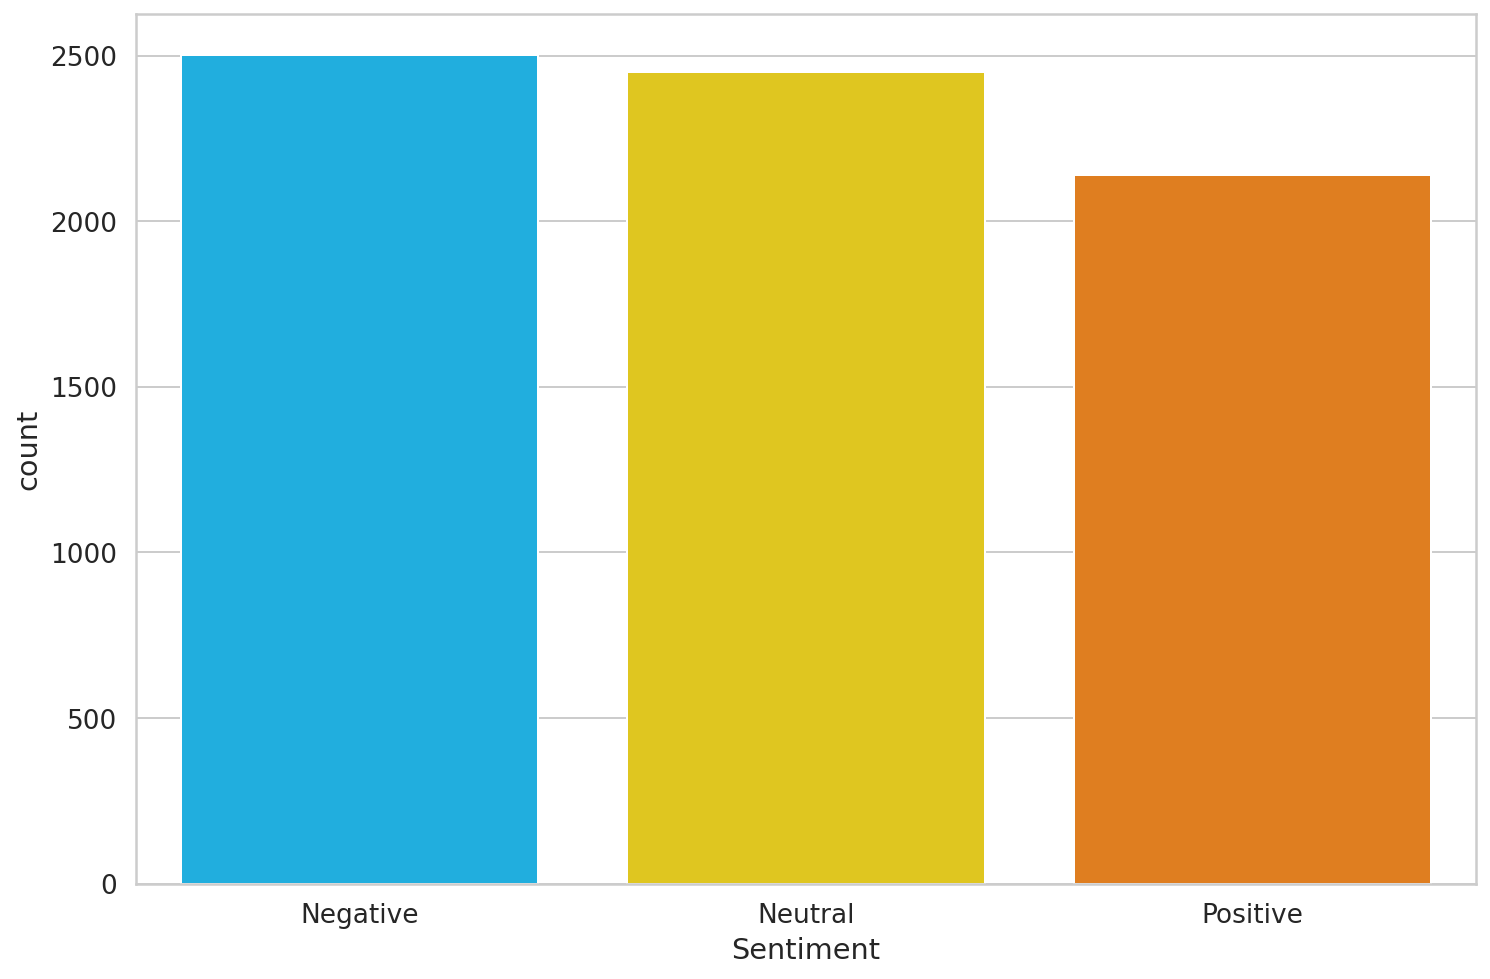

In [169]:
# PLOTTING THE SENTIMENTS IN DESCENDING ORDER
ax = sns.countplot(data.sentiment)
plt.xlabel('Sentiment')
ax.set_xticklabels(class_names);
from google.colab import files
plt.savefig('Sentiment_Score.pdf')    # SAVING THE PLOTTED GRAPH
files.download('Sentiment_Score.pdf') # DOWNLOADING THE PLOTTED GRAPH

In [0]:
# NUMBER 2: DATA PREPROCESSING
# WE'LL USE THE CASED VERSION SINCE IT PERFORMS BETTER THAN UNCASED
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
# LOADING PRE-TRAINED BERT TOKENIZER
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
# CREATING A SAMPLE TEXT IN ORDER TO UNDERSTAND THE TOKENIZATION PROCESS
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks'

In [173]:
# CONVERTING THE TEXT WE'VE CREATED ABOVE TO TOKENS THEN CONVERTING THE TOKEN TO UNIQUE INTEGER IDS
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}') # PRINTING THE SENTENCE
print(f'   Tokens: {tokens}')     # PRINTING THE TOKENS CREATED
print(f'Token IDs: {token_ids}')  # PRINTING THE IDS CREATED

 Sentence: When was I last outside? I am stuck at home for 2 weeks
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277]


In [178]:
# SPECIAL TOKENS
# [SEP]- MARKER FOR ENDING OF A SENTENCE
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [179]:
# [CLS]- THIS TOKEN SHOULD BE ADDED BEFORE EVERY SENTENCE IN ORDER FOR BERT TO KNOW WE ARE DOING CLASSIFICATION
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [180]:
# [PAD]- SPECIAL TOKEN USED FOR PADDING
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [181]:
# [UNK]- UNKNOWN TOKEN. BERT UNDERSTANDS EVERYTHING THAT WAS IN THE TRAINING SET EVERY OTHER DATA CAN BE ENCODED WITH THE UNK TOKEN
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [182]:
# USING ENCODE_PLUS() METHOD
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,       # ADDS '[CLS]' and '[SEP]' TO THE SENTENCES
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',           # RETURNING PYTORCH SENSORS
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [183]:
# THE TOKENS ARE STORED IN A TENSOR 
print(len(encoding['input_ids'][0])) # PRINTING THE TOKENNS CONTAINED IN THE TENSOR AND THE PADDING LENGTH
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [184]:
# DISPLAYING THE ATTENTION MASK TOKENS 
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [185]:
# INVERSING OUR TOKENS SO AS TO HAVE A LOOK AT THE SPECIAL TOKENS WE CREATED
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [0]:
token_lens = []
for txt in data.Tweet:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

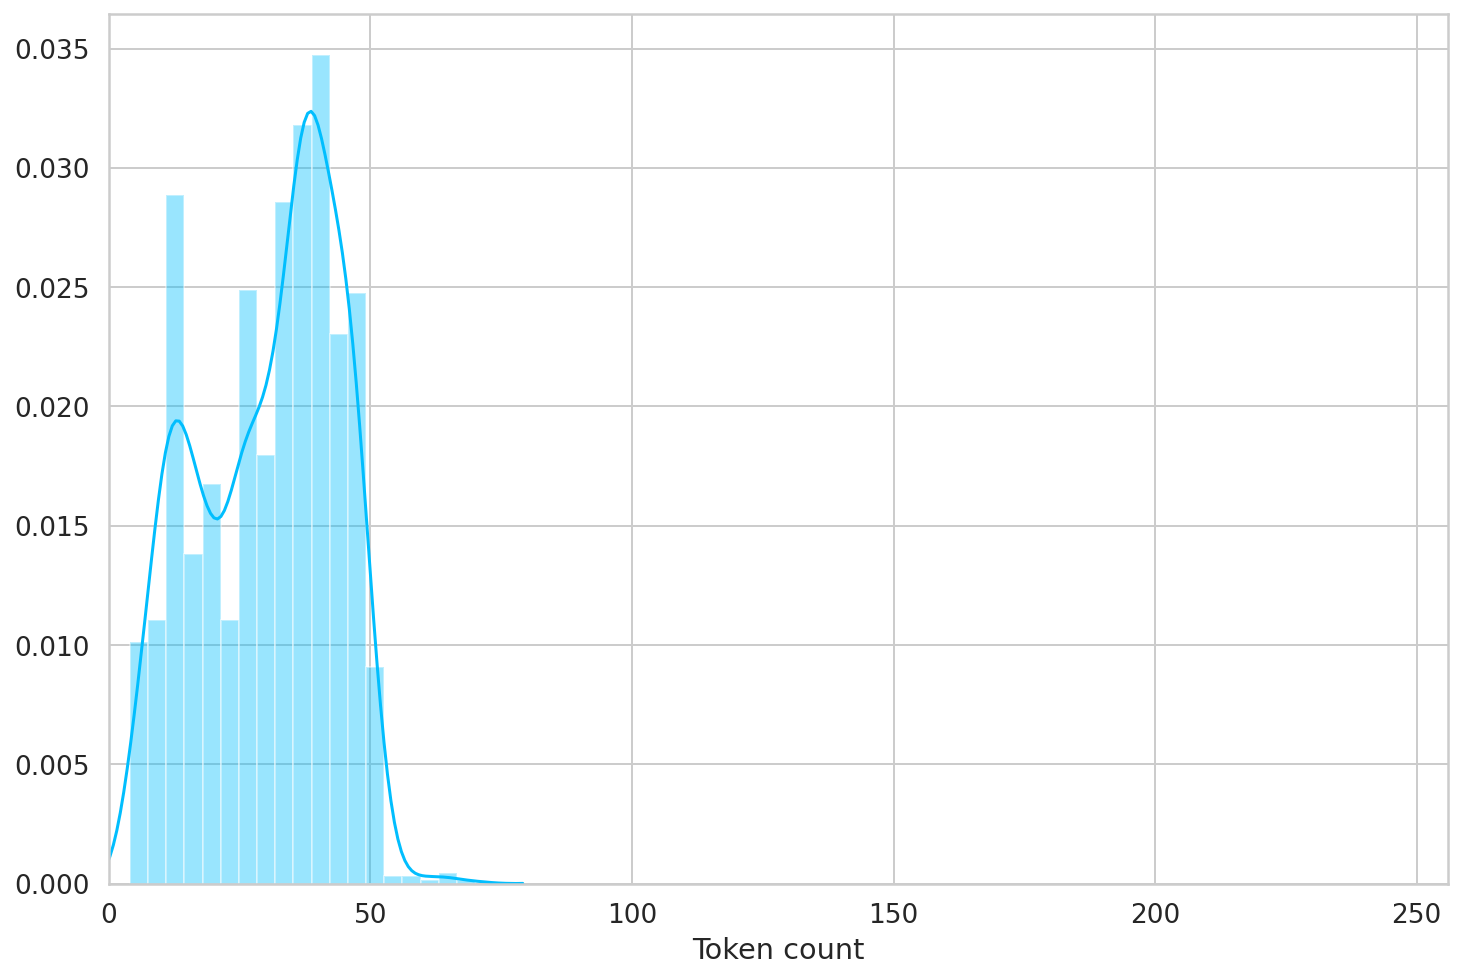

In [154]:
# NUMBER 3: CHOOSING THE SEQUENCE LENGTH
# PLOTTING THE DISTRTIBUTION OF OUR TOKEN LENGTH
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
from google.colab import files
plt.savefig('Token.pdf')     # SAVING THE PLOTTED GRAPH
files.download('Token.pdf')  # DOWNLOADING THE PLOTTED GRAPH

In [0]:
MAX_LEN = 100

In [0]:
# CREATING OUR PYTORCH DATASET SINCE WE HAVE EVERYTHING WE REQUIRE
class GPSentimentDataset(Dataset):
  def __init__(self, sentiments, targets, tokenizer, max_len):
    self.sentiments = sentiments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.sentiments)
  
  def __getitem__(self, item):
    sentiment = str(self.sentiments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentiment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'sentiment_text': sentiment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
# EVALUATING THE PREDICTIONS FROM OUR MODEL
data_train, data_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)     # TRAIN DATASET
data_val, data_test = train_test_split(data_test, test_size=0.5, random_state=RANDOM_SEED)  # VALIDATION DATASET

In [189]:
data_train.shape, data_val.shape, data_test.shape

((6382, 4), (355, 4), (355, 4))

In [0]:
# CREATING DATA LOADERS FOR THE BERT MODEL
def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = GPSentimentDataset(
    sentiments=data.Sentiment.to_numpy(),
    targets=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [192]:
# EXAMPLE OF OUR BATCH FROM THE TRAIN DATA LOADER
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sentiment_text', 'input_ids', 'attention_mask', 'targets'])

In [193]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [0]:
# SENTIMENT CLASSIFICATION USING THE BERT MODEL
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # LOADING A PRE TRAINED BERT MODEL

In [0]:
# WE ARE USING THE BERT MODEL WE'VE LOADED ABOVE TO ENCODE THE SAMPLE TEXT WE CREATED ABOVE
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [196]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [197]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
# WE'RE CREATING A CLASSIFIER THAT USES THE BERT MODEL
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [200]:
# MOVING THE EXAMPLE BATCH OF OUR TRAINING DATA TO THE GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [201]:
# APPLYING SOFTMAX FUNCTION TO THE OUTPUT IN ORDER TO GET THE PREDICTED PROBABILITIES OF OUR TRAINED MODEL
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5181, 0.1827, 0.2992],
        [0.4257, 0.1025, 0.4718],
        [0.5046, 0.0926, 0.4027],
        [0.5126, 0.0688, 0.4186],
        [0.3803, 0.1457, 0.4740],
        [0.2314, 0.1728, 0.5957],
        [0.3326, 0.2020, 0.4655],
        [0.3943, 0.1490, 0.4567],
        [0.3736, 0.0786, 0.5478],
        [0.4190, 0.1172, 0.4638],
        [0.4453, 0.1654, 0.3893],
        [0.3223, 0.1367, 0.5409],
        [0.5376, 0.0865, 0.3759],
        [0.2459, 0.2037, 0.5504],
        [0.2962, 0.1625, 0.5413],
        [0.5967, 0.0968, 0.3065]], grad_fn=<SoftmaxBackward>)

In [0]:
# SETTING UP OUT OPTIMIZER AND SCHEDULER 
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)  # WE'RE USING THE ADAMW OPTIMIZER PROVIDED BY HUGGING FACE
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(                        # WE'RE USING THE LINEAR SCHEDULER 
  optimizer,
  num_warmup_steps=0,                                               # WE'RE USING THE LINEAR SCHEDULER WITH NO WARM UP STEPS
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
# HELPER FUNCTION FOR TRAING OUR MODEL FOR ONE EPOCH
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
# HELPER FUNCTION THAT HELPS US EVALUATE THE MODEL ON A GIVEN DATA LOADER
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
# CREATING OUR TRAINING LOOP AND STORING THE TRAINING HISTORY
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 5)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(data_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(data_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
-----
Train loss 0.020007351090765253 accuracy 0.9916953932936383
Val   loss 3.633700148582094e-05 accuracy 1.0

Epoch 2/5
-----
Train loss 4.6152372912426166e-05 accuracy 1.0
Val   loss 2.3330191533718988e-05 accuracy 1.0

Epoch 3/5
-----
Train loss 3.313541271283821e-05 accuracy 1.0
Val   loss 1.812256177009144e-05 accuracy 1.0

Epoch 4/5
-----
Train loss 2.7546209584532672e-05 accuracy 1.0
Val   loss 1.5716712566601295e-05 accuracy 1.0

Epoch 5/5
-----
Train loss 2.495618982014146e-05 accuracy 1.0
Val   loss 1.4960653219453018e-05 accuracy 1.0

CPU times: user 8h 12min 2s, sys: 12min 57s, total: 8h 25min
Wall time: 8h 25min 23s


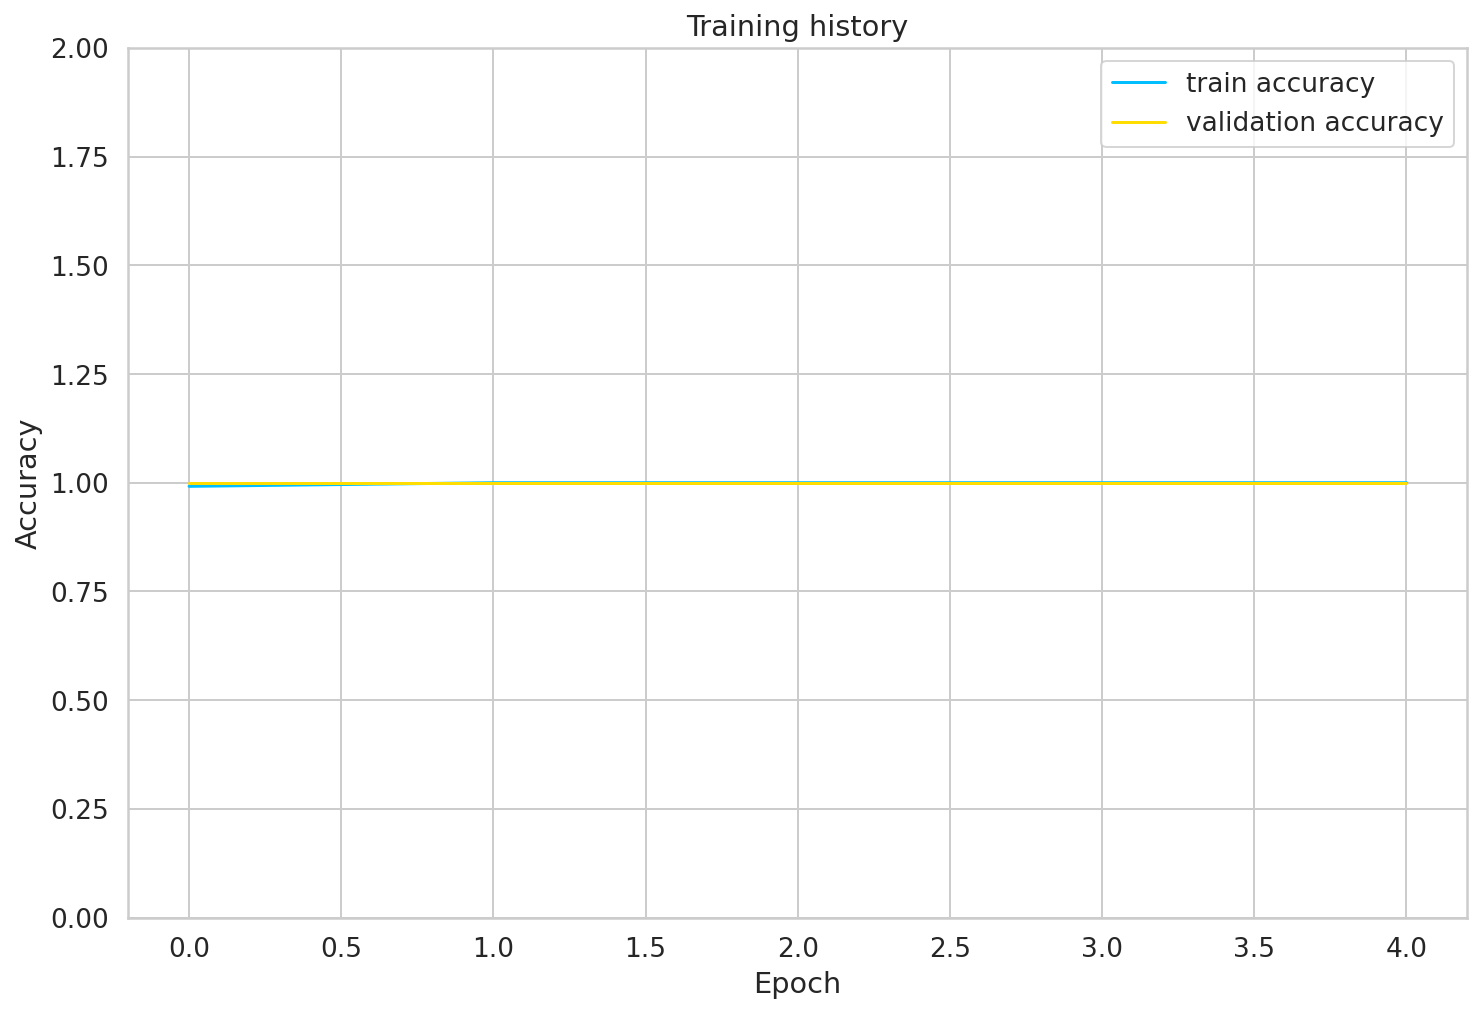

In [205]:
# PLOTTING OUR TRAINING VS VALIDATION ACCURACY
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);
from google.colab import files
plt.savefig('Training_Graph.pdf')    # SAVING THE LOTTED GRAPH
files.download('Training_Graph.pdf') # DOWNLOADING THE PLOTTED GRAPH

In [0]:
# EVALUATING THE ACCURACY OF OUR MODEL
test_acc, _ = eval_model(   # EVALUATING THE ACCURACY OF OUR TEST DATA
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)
test_acc.item()

In [0]:
# HELPER FUNCTION TO GET PREDICTIONS FROM OUR MODEL
def get_predictions(model, data_loader):
  model = model.eval()
  
  sentiment_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["sentiment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)
      sentiment_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentiment_texts, predictions, prediction_probs, real_values

In [0]:
y_sentiment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [0]:
# PRINTING THE CLASSIFICATION REPORT
print(classification_report(y_test, y_pred, target_names=class_names))

In [0]:
# PLOTTING OUR CONFUSION MATRIX
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(data_cm)
from google.colab import files
plt.savefig('Confusion_Matrix.pdf')      # SAVING THE PLOTTED GRAPH
files.download('Confusion_Matrix.pdf')   # DOWNLOADING THE PLOTTED GRAPH

In [0]:
# EVALUATING OUR TEST DATA
idx = 2
sentiment_text = y_sentiment_texts[idx]
true_sentiment = y_test[idx]
pred_data = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [150]:
# PRINTING THE TEST DATA
print("\n".join(wrap(sentiment_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

töte ihn!!!

True sentiment: Negative


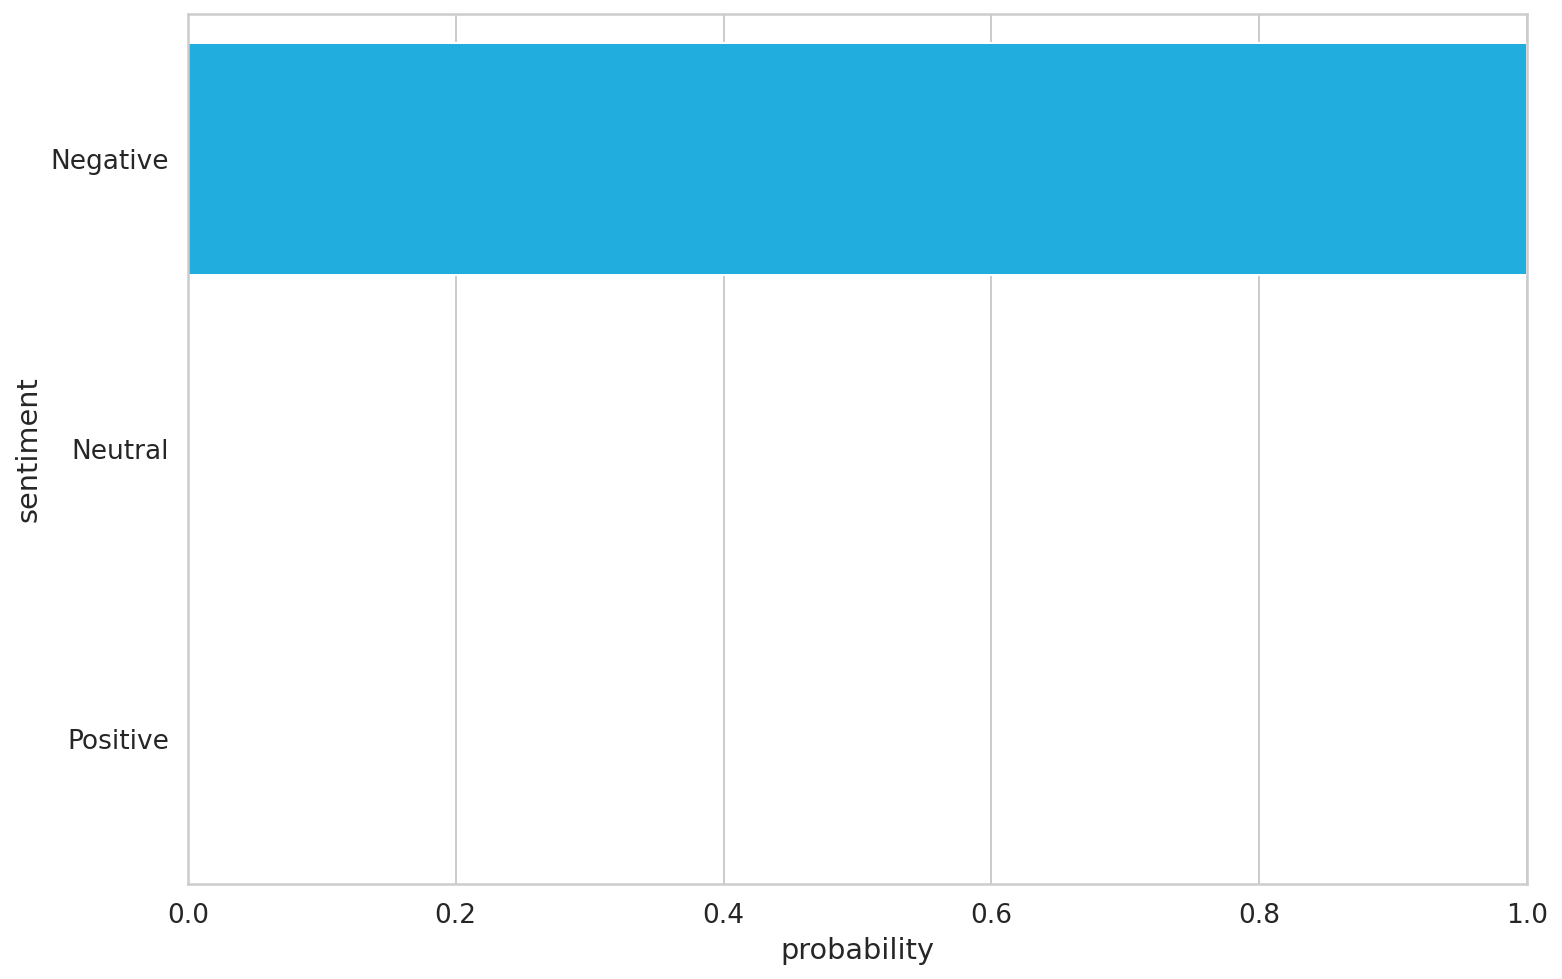

In [151]:
# PLOTTING THE CONFIDENCE OF EACH SENTIMENT OF OUR MODEL
sns.barplot(x='values', y='class_names', data=pred_data, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);
from google.colab import files
plt.savefig('Confidence.pdf')
files.download('Confidence.pdf')

In [0]:
# PREDICTING THE SENTIMENT OF RAW TEXT
sentiment_text = "töte ihn!!!"

In [0]:
# USING THE TOKENIZER TO ENCODE THE RAW TEXT
encoded_sentiment = tokenizer.encode_plus(
  sentiment_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [149]:
# GETTING PREDICTIONS OF THE RAW TEXT FROM OUR MODEL
input_ids = encoded_sentiment['input_ids'].to(device)
attention_mask = encoded_sentiment['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Tweet text: {sentiment_text}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet text: töte ihn!!!
Sentiment  : Negative
